In [85]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import ast
%matplotlib inline

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Read the CSV file from Google Drive
data = pd.read_csv('/content/listings.csv')

# Print the first rows
print(data.head())

        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits at

In [8]:
# Features for the project
proj_features = ['summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'zipcode', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price',  'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'calculated_host_listings_count',
       'reviews_per_month']



In [23]:
# Dataset for the project:
df = data[proj_features]
print(df.shape)

(3818, 53)


In [30]:
# Delete the columns with more than 50% missing values

df = df[df.columns[df.isnull().sum() < .5*df.shape[0]]]

# Delete the rows if the neighbourhoods missing
df = df = df.dropna(subset=['neighbourhood'])


print(df.shape)

(2837, 52)


In [45]:
# Determine the categorical and numerical columns
df.info()
cat_vars = list(df.select_dtypes(include = 'object'))
num_vars = list(df.select_dtypes(include = ['float64', 'int64']))
print(num_vars)

<class 'pandas.core.frame.DataFrame'>
Index: 2837 entries, 0 to 3814
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   summary                         2682 non-null   object 
 1   space                           2558 non-null   object 
 2   description                     2837 non-null   object 
 3   experiences_offered             2837 non-null   object 
 4   neighborhood_overview           2200 non-null   object 
 5   notes                           1813 non-null   object 
 6   transit                         2282 non-null   object 
 7   host_response_time              2555 non-null   object 
 8   host_response_rate              2555 non-null   object 
 9   host_acceptance_rate            2411 non-null   object 
 10  host_listings_count             2837 non-null   float64
 11  host_total_listings_count       2837 non-null   float64
 12  host_verifications              2837 no

In [49]:
# Delete the rows with missing numeric values
df = df.dropna(subset = num_vars)

In [47]:
# Create mum_amenities column showing the number of amenities at home
def count_amenities(amenities_str):
  # Remove curly braces and split by comma
  amenities_list = amenities_str.strip('{}').split(',')

  # Find the number of amenities
  return len(amenities_list)

# Create a column with the number of amenities
df['num_amenities'] = df['amenities'].apply(count_amenities)

Question 1) What are the predictors of price?


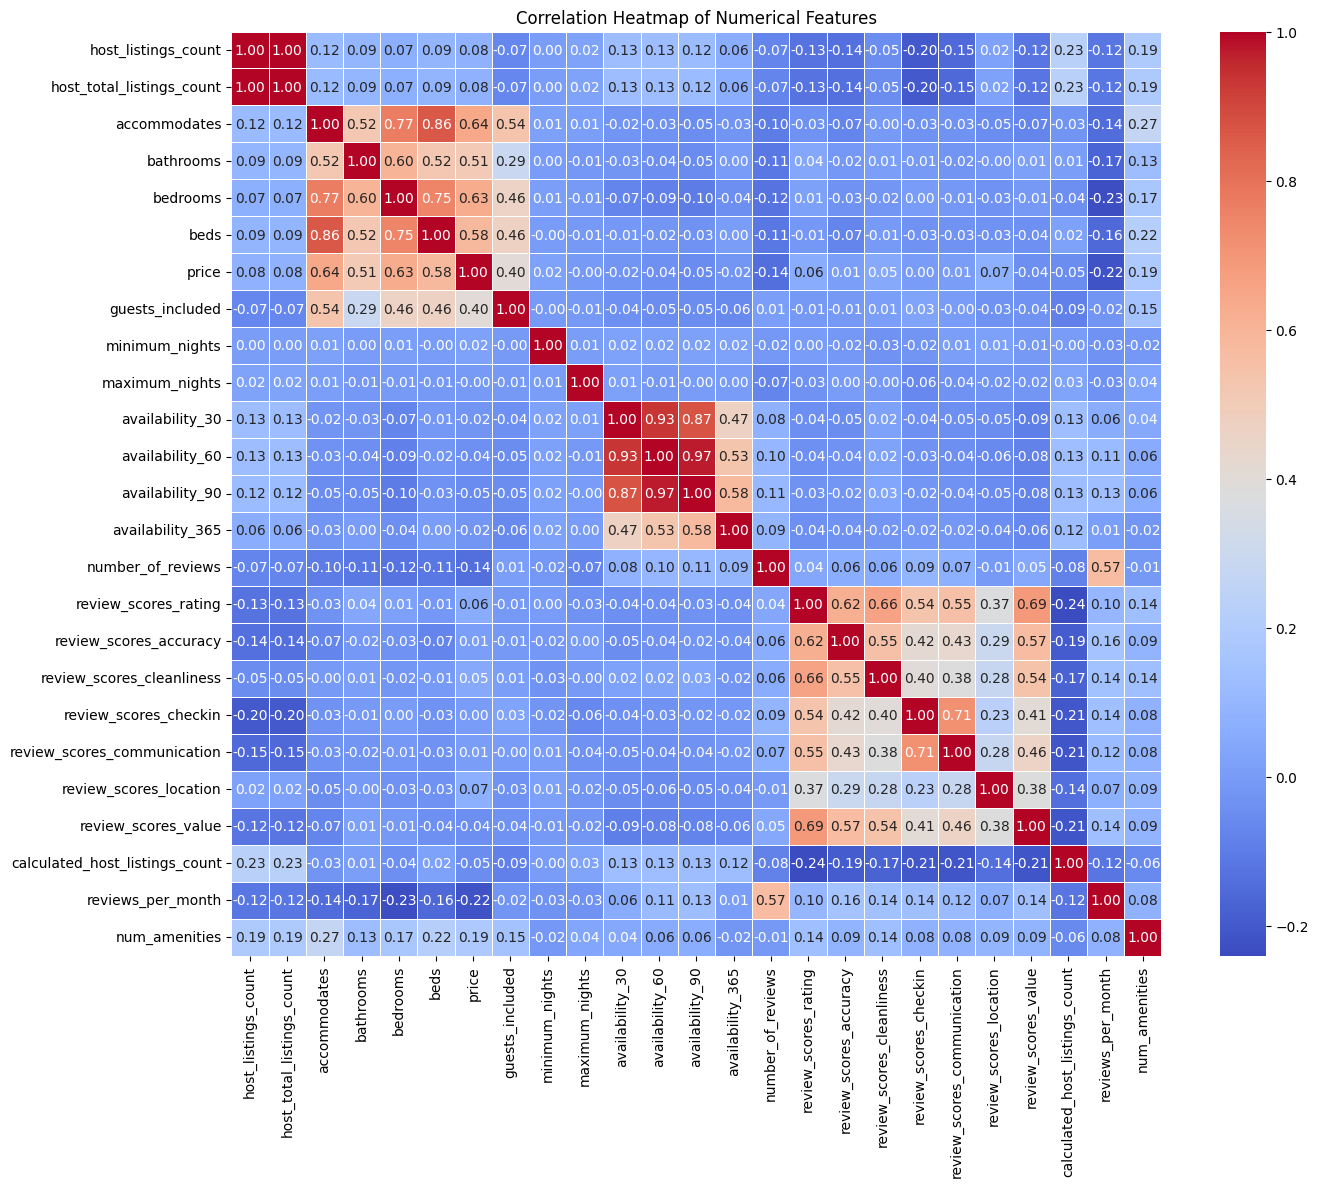

In [48]:
# clean the 'price' column
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Compute the correlation matrix
corr_matrix = df[num_vars].corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [63]:
# Create a new dataframe including the features to predict the price

prc_df = df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'num_amenities',
 'zipcode','bed_type', 'price']]
prc_df.info()
prc_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2837 entries, 0 to 3814
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   accommodates     2837 non-null   int64  
 1   bathrooms        2837 non-null   float64
 2   bedrooms         2837 non-null   float64
 3   beds             2837 non-null   float64
 4   guests_included  2837 non-null   int64  
 5   num_amenities    2837 non-null   int64  
 6   zipcode          2833 non-null   object 
 7   bed_type         2837 non-null   object 
 8   price            2837 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 221.6+ KB


,accommodates,bathrooms,bedrooms,beds,guests_included,num_amenities,zipcode,bed_type,price
0,4,1.0,1.0,1.0,2,10,98119,Real Bed,85.0
1,4,1.0,1.0,1.0,1,16,98119,Real Bed,150.0
2,11,4.5,5.0,7.0,10,21,98119,Real Bed,975.0
4,6,2.0,3.0,3.0,6,13,98119,Real Bed,450.0
5,2,1.0,1.0,1.0,1,6,98119,Real Bed,120.0


In [66]:
# Group zipcodes with fewr than 100 members into 'Other' category.

len(prc_df['zipcode'].unique())
prc_df.groupby('zipcode').size()

# Calculate the size of each group
zipcode_counts = prc_df['zipcode'].value_counts()

# Identify zipcodes with fewer than 100 members
zipcodes_to_replace = zipcode_counts[zipcode_counts < 100].index

# Replace these zipcodes with "Other"
prc_df['zipcode'] = prc_df['zipcode'].apply(lambda x: 'Other' if x in zipcodes_to_replace else x)

# Display the modified DataFrame to confirm changes
print(prc_df['zipcode'].value_counts())

# Drop the rows with missing zipcodes
prc_df.dropna(subset = ['zipcode'], inplace = True)

prc_df.shape

zipcode
Other    455
98122    337
98103    285
98102    242
98105    159
98101    157
98121    152
98144    149
98109    142
98107    139
98117    131
98115    130
98118    124
98112    123
98119    108
Name: count, dtype: int64


<ipython-input-66-dfd67ec65076>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prc_df['zipcode'] = prc_df['zipcode'].apply(lambda x: 'Other' if x in zipcodes_to_replace else x)
<ipython-input-66-dfd67ec65076>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prc_df.dropna(subset = ['zipcode'], inplace = True)


(2833, 9)

In [67]:
# Encode the categorical variables

# Display unique values before encoding
print("Unique zipcodes:", prc_df['zipcode'].unique())
print("Unique bed types:", prc_df['bed_type'].unique())

# Perform one-hot encoding on 'zipcode' and 'bed_type'
prc_df_encoded = pd.get_dummies(prc_df, columns=['zipcode', 'bed_type'], drop_first=True)

# Display the first few rows of the new DataFrame to confirm encoding
print(prc_df_encoded.head())


Unique zipcodes: ['98119' '98109' '98107' '98117' '98103' '98105' '98115' '98122' '98112'
 '98144' '98101' '98121' '98102' 'Other' '98118']
Unique bed types: ['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
   accommodates  bathrooms  bedrooms  beds  guests_included  num_amenities  \
0             4        1.0       1.0   1.0                2             10   
1             4        1.0       1.0   1.0                1             16   
2            11        4.5       5.0   7.0               10             21   
4             6        2.0       3.0   3.0                6             13   
5             2        1.0       1.0   1.0                1              6   

   price  zipcode_98102  zipcode_98103  zipcode_98105  ...  zipcode_98118  \
0   85.0          False          False          False  ...          False   
1  150.0          False          False          False  ...          False   
2  975.0          False          False          False  ...          False   
4  450.0   

In [70]:
# Create the response and feature datasets
X = prc_df_encoded.drop(['price'], axis = 1)
y = prc_df_encoded['price']

# Bin the target variable
y_binned = pd.qcut(y, q=10, labels=False)

# Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y_binned)

In [71]:
# Create and fit the model
# Train the linear model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict using the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R^2 Score: {r2}')
print(f'Mean Squared Error: {mse}')


R^2 Score: 0.4455479520027277
Mean Squared Error: 5544.286977001229


                        Coefficient
bedrooms                  31.745141
zipcode_98109             27.800319
bed_type_Real Bed         25.249570
bathrooms                 21.402561
bed_type_Pull-out Sofa    19.884977
bed_type_Futon            16.739441
zipcode_98121             15.661661
zipcode_98119             12.652860
accommodates              12.323478
guests_included            5.248445
beds                       0.505968
num_amenities              0.339216
zipcode_98102             -6.429740
zipcode_98122            -10.099332
zipcode_98112            -14.772307
bed_type_Couch           -16.908636
zipcode_98107            -20.062108
zipcode_Other            -25.411431
zipcode_98103            -27.360653
zipcode_98105            -30.216729
zipcode_98115            -36.762468
zipcode_98144            -39.454117
zipcode_98117            -42.036283
zipcode_98118            -48.122232


<Figure size 1000x800 with 0 Axes>

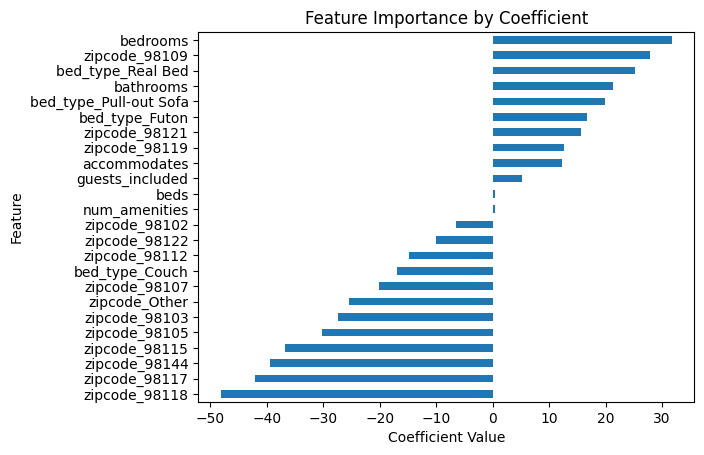

In [74]:
# Retrieve and display coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients.sort_values(by='Coefficient', ascending=False))

# Plot coefficients
plt.figure(figsize=(10, 8))
coefficients.sort_values(by='Coefficient', ascending=True).plot(kind='barh', legend=False)
plt.title('Feature Importance by Coefficient')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Summary of the findings:
### Summary of Coefficient Interpretation

The coefficients obtained from the linear regression model provide valuable insights into how different features impact the price of Airbnb listings. These insights can be categorized into two main groups: positive coefficients and negative coefficients.

### Positive Coefficients

Features with positive coefficients are associated with an increase in the price of Airbnb listings. The magnitude of these coefficients indicates the strength of their impact on the price. Key features with positive coefficients include:

1. **Bedrooms (31.745141)**:
   - Listings with more bedrooms tend to have significantly higher prices. This is logical as properties with more bedrooms can accommodate larger groups and offer more space and privacy.

2. **Bathrooms (21.402561)**:
   - An increase in the number of bathrooms is positively correlated with higher prices. More bathrooms improve convenience and comfort, especially for larger groups or families.

3. **Bed Type - Real Bed (25.249570)**:
   - Listings that offer a real bed are priced higher than those without. Real beds are generally more comfortable and preferred by guests, thus commanding higher prices.

4. **Bed Type - Pull-out Sofa (19.884977) and Futon (16.739441)**:
   - Listings with pull-out sofas and futons also command higher prices. These types of beds provide additional flexibility in accommodating guests.

5. **Zipcodes 98109, 98121, 98119**:
   - Properties located in these zipcodes are associated with higher prices, suggesting that these are desirable locations.

6. **Accommodates (12.323478)**:
   - The number of guests a property can accommodate is positively correlated with price. Larger properties that can host more guests naturally charge higher rates.

7. **Guests Included (5.248445)**:
    - The number of guests included in the base price also positively impacts the price. Listings that include more guests in the base price can justify higher pricing.

8. **Beds (0.505968)**:
    - The number of beds, although having a smaller impact, still positively correlates with the price. More beds can mean more flexibility in guest accommodation.

9. **Number of Amenities (0.339216)**:
    - A higher number of amenities slightly increases the price. This reflects that more amenities add value to the listing, making it more attractive to potential guests.

### Negative Coefficients

Features with negative coefficients are associated with a decrease in the price of Airbnb listings. The magnitude of these coefficients indicates the strength of their impact on reducing the price. Key features with negative coefficients include:

1. **Bed Type - Couch (-16.908636)**:
   - Listings that offer a couch as a bed type are associated with lower prices. Couches are likely seen as less comfortable and desirable compared to other bed types.

2. **Other Zipcodes**:
   - Several other zipcodes (98102, 98122, 98112, 98107, etc.) are associated with lower prices, indicating that properties in these areas are less in demand compared to those in higher-priced zipcodes.

### Overall Insights

- **Desirable Features**: More bedrooms, bathrooms, real beds, and specific zipcodes (98109, 98121, 98119) significantly increase the price of Airbnb listings.
- **Less Desirable Features**: Certain zipcodes (98102, 98122, 98112, etc.) and couch bed types are associated with lower prices.
- **Value-Adding Features**: While the number of beds and amenities positively impact the price, their effect is smaller compared to major factors like bedrooms and location.

These insights can help property owners and managers understand what features to highlight or improve in their listings to optimize pricing. It also aids in market analysis and strategic decisions regarding property investments and enhancements.


# Question 2: What are the average prices in different neighborhoods?

<ipython-input-79-ea34f0016094>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zipcode_price_df, x='price', y='zipcode', palette='viridis')


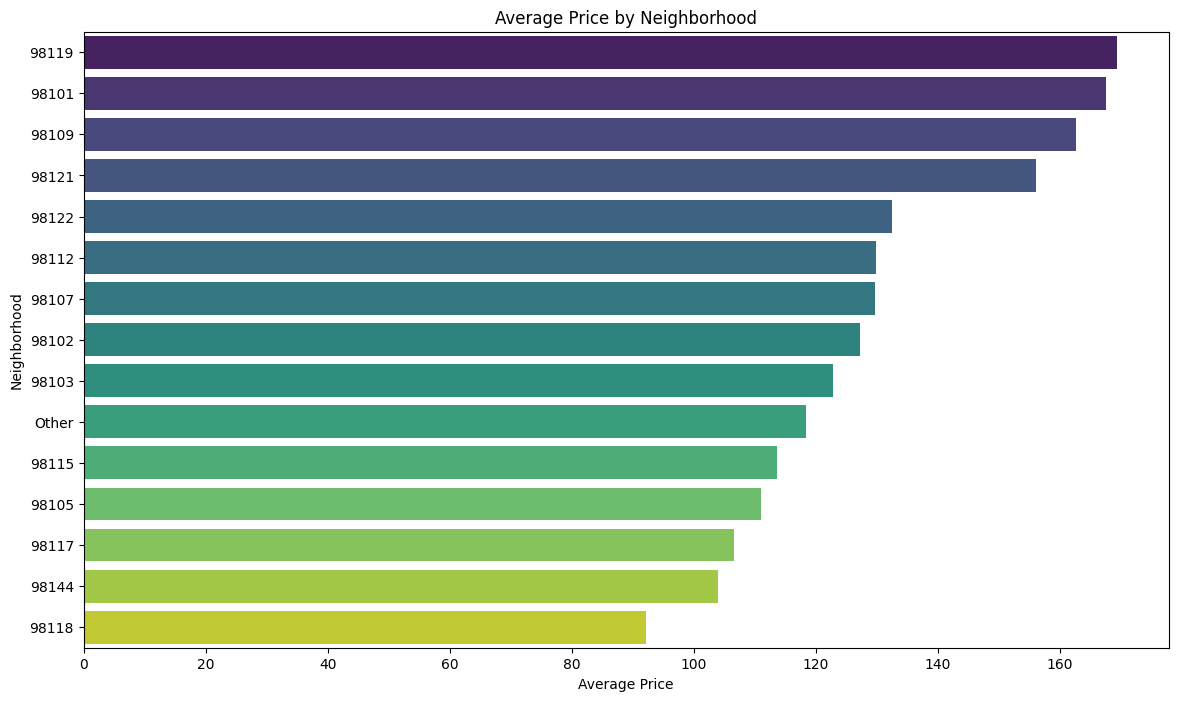

In [79]:
# Calculate average price by neighborhood
zipcode_price_df = prc_df.groupby('zipcode')['price'].mean().reset_index()

# Sort by average price
zipcode_price_df = zipcode_price_df.sort_values(by='price', ascending=False)

# Plot the results
plt.figure(figsize=(14, 8))
sns.barplot(data=zipcode_price_df, x='price', y='zipcode', palette='viridis')
plt.title('Average Price by Neighborhood')
plt.xlabel('Average Price')
plt.ylabel('Neighborhood')
plt.show()


<ipython-input-80-ead0ab94ed94>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_bottom_zipcodes, x='price', y='zipcode', palette='coolwarm')


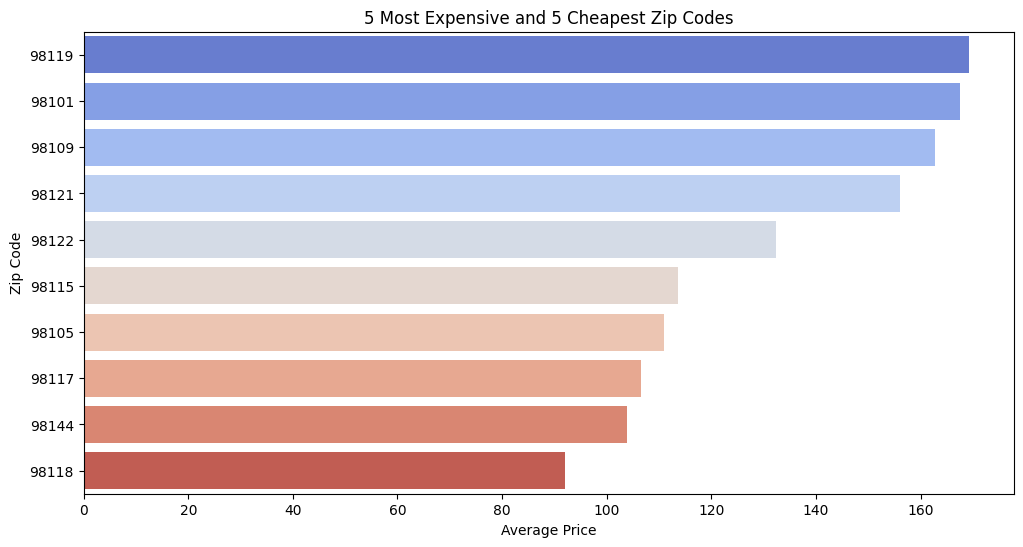

In [80]:
# Select the 5 most expensive and 5 cheapest zip codes
top_5_expensive = zipcode_price_df.head(5)
top_5_cheapest = zipcode_price_df.tail(5)

# Combine the two dataframes
top_bottom_zipcodes = pd.concat([top_5_expensive, top_5_cheapest])

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bottom_zipcodes, x='price', y='zipcode', palette='coolwarm')
plt.title('5 Most Expensive and 5 Cheapest Zip Codes')
plt.xlabel('Average Price')
plt.ylabel('Zip Code')
plt.show()

# Question 3: What is the relationship between property type and room type?

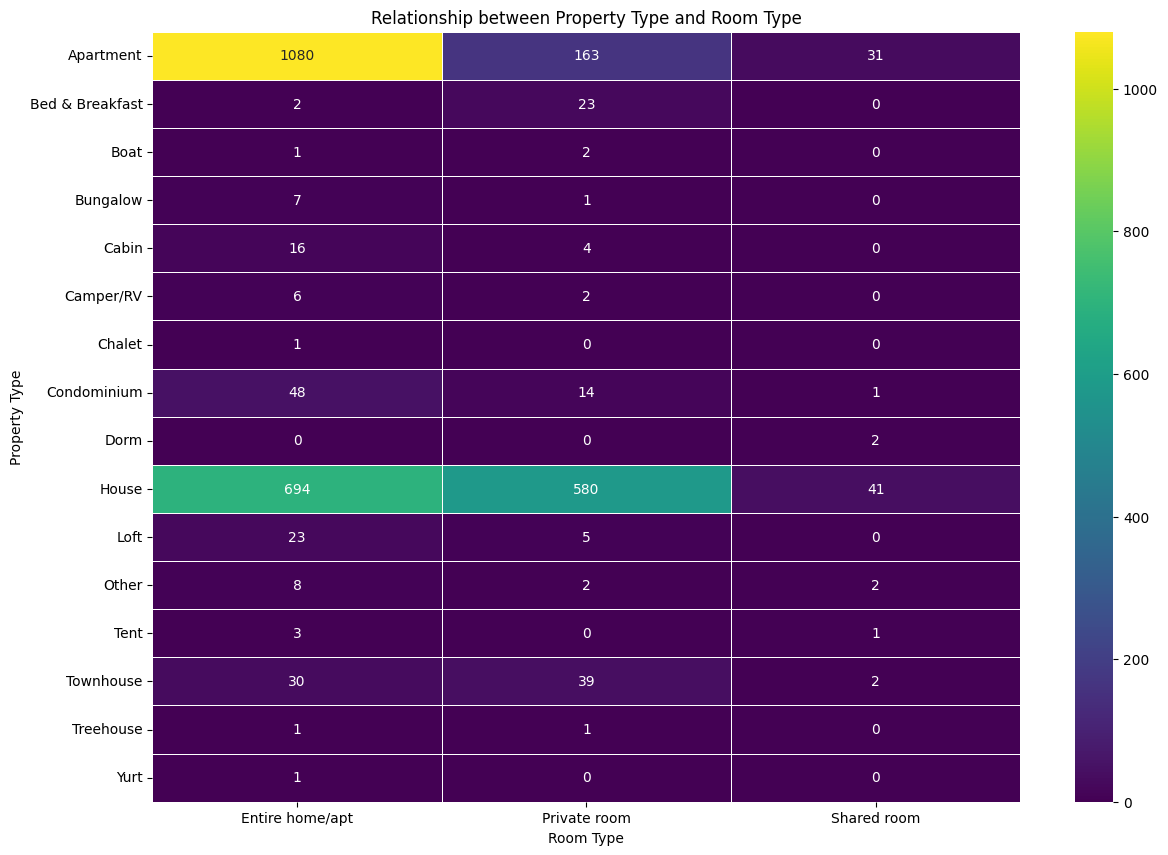

In [88]:
# Create a cross-tabulation of property type and room type
property_room_crosstab = pd.crosstab(df['property_type'], df['room_type'])

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(property_room_crosstab, annot=True, fmt='d', cmap='viridis', linewidths=.5)
plt.title('Relationship between Property Type and Room Type')
plt.xlabel('Room Type')
plt.ylabel('Property Type')
plt.show()


### Summary of the Crosstab: Relationship between Property Type and Room Type

The heatmap visualization illustrates the distribution of room types across different property types in Airbnb listings. Key insights include:

1. **Apartments**:
   - **Entire home/apt**: The most common combination with 1080 listings, indicating a strong preference for renting out entire apartments.
   - **Private room**: Less common with 163 listings.
   - **Shared room**: Rare with only 31 listings.

2. **Houses**:
   - **Entire home/apt**: A significant number of listings (694), showing that many houses are rented out entirely.
   - **Private room**: Also popular with 580 listings, suggesting many hosts offer rooms within their homes.
   - **Shared room**: Less common with 41 listings.

3. **Bed & Breakfast**:
   - **Private room**: Predominantly listed as private rooms (23 listings), which is typical for this property type.
   - **Entire home/apt**: Rare with only 2 listings.

4. **Condos**:
   - **Entire home/apt**: Most common with 48 listings.
   - **Private room**: Less frequent with 14 listings.
   - **Shared room**: Very rare with just 1 listing.

5. **Lofts and Townhouses**:
   - **Lofts**: Primarily listed as entire homes (23 listings) with a few private rooms (5 listings).
   - **Townhouses**: Balanced distribution between entire homes (30 listings) and private rooms (39 listings), with very few shared rooms (2 listings).

6. **Specialty Properties**:
   - **Bungalows, Cabins, Camper/RVs, Chalets, Tents, Treehouses, Yurts**: These have few listings overall but offer unique accommodations mostly as entire homes or private rooms.
   - **Dorms**: Exclusively listed as shared rooms (2 listings).

### Overall Observations:

1. **Dominance of Entire Home/Apt Listings**:
   - Entire homes/apartments are the most prevalent room type across various property types, especially for apartments and houses, indicating a preference among hosts to rent out entire properties.

2. **Significance of Private Rooms**:
   - Private rooms are also a popular choice, particularly in houses and townhouses, showing that many hosts are willing to share their living spaces.

3. **Limited Shared Rooms**:
   - Shared rooms are the least common across almost all property types, suggesting they are less preferred by both hosts and guests.

4. **Niche Market for Specialty Properties**:
   - Properties like Bed & Breakfasts, Boats, Bungalows, and Treehouses have fewer listings but cater to specific guest preferences looking for unique stays.

This analysis provides a clear understanding of how different property types are utilized in Airbnb listings, highlighting host preferences and potential guest demands for various accommodation types.